In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

# from statsmodels.regression.linear_model import OLS

In [2]:
process = 'components'
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis'
data_dir = f'{top_dir}/data/raw'
out_dir = f'{top_dir}/data/interim'
figure_dir = f'{top_dir}/reports/figures/{process}'
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

In [3]:
X = []
mask = np.load(f'{out_dir}/group_reliability/sub-all_reliability-mask.npy').astype('bool')
n_voxels = sum(mask)
for sid_ in range(4):
    sid = str(sid_+1).zfill(2)
    betas = np.load(f'{out_dir}/grouped_runs/sub-{sid}/sub-{sid}_train-data.npy')
    tot_voxels = betas.shape[0]

    #Filter the beta values to the reliable voxels
    betas = betas[mask, :]
    
    #Mean center the activation within subject
    offset_subject = betas.mean()
    betas -= offset_subject

    if type(X) is list:
        X = betas.T
    else:
        X = np.hstack([X, betas.T])
X_scaled = StandardScaler().fit_transform(X)

In [20]:
pca = PCA(whiten=True, svd_solver='full', n_components=10)
videos_by_comp = pca.fit_transform(X_scaled)
comp_by_voxels = pca.components_

avg = comp_by_voxels.reshape((-1, 4, n_voxels)).mean(axis=-2)

In [25]:
comp_by_voxels.shape

(10, 484060)

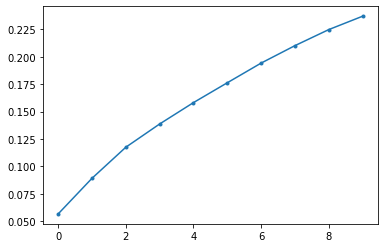

In [21]:
plt.plot(pca.explained_variance_ratio_.cumsum(), '.-')

In [22]:
df = pd.read_csv(f'{data_dir}/annotations/annotations.csv')
train = pd.read_csv(f'{data_dir}/annotations/train.csv')
df = df.merge(train)
df.sort_values(by=['video_name'], inplace=True)
features = df.columns.to_list()
features.remove('video_name')

In [23]:
d = pd.DataFrame()
for feature in features:
    for i in range(videos_by_comp.shape[-1]):
        pc = f'PC{i+1}'
        prod = np.dot(df[feature], videos_by_comp[:, i])
        new = pd.DataFrame({'feature': feature, 'pc': pc, 'prod': [prod]})
        d = pd.concat([d, new], ignore_index=True)

In [24]:
for i in range(videos_by_comp.shape[-1]):
    print(f'PC{i+1}')
    print(d[d.pc == f'PC{i+1}'].drop(columns=['pc']).sort_values(by='prod', ascending=False).reset_index(drop=True))
    print()

PC1
           feature       prod
0     transitivity  19.985889
1          expanse   6.483130
2          arousal   6.137157
3   agent distance   5.274591
4        dominance   0.520696
5     joint action  -0.547733
6          valence  -2.877507
7      cooperation  -3.469198
8         intimacy  -4.819379
9       facingness  -9.077732
10   communication -12.352981
11          indoor -17.918577

PC2
           feature       prod
0           indoor  19.486860
1        dominance  14.983131
2       facingness  14.141113
3         intimacy  11.877575
4          arousal  10.938274
5     joint action   7.772596
6          valence   0.567219
7    communication  -1.646020
8      cooperation  -3.325923
9          expanse -10.622149
10    transitivity -11.807424
11  agent distance -16.170969

PC3
           feature       prod
0           indoor  13.810319
1    communication  12.680467
2       facingness   8.768725
3          arousal   7.551127
4     joint action   3.536498
5   agent distance   0.515